# Neto customer churn predict project

## Summary

This is a data project to see if we can take customer data from the Neto platform and categorise and hopefully in the end "predict" when a customer is likely to churn. There will be a heap of assumptions which I will note in here.

### Research links

https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction/data

### Assumptions

- churn can be indicated by last login date of an account
- usage behaviour of a customers use of the export system could indicate signs of churn

### Data observation

`Neto License Registration Date` and `Go Live Date` are sometime entered "backwards" so when calulating the `go live days` I am taking the absolute value so I dont get a negative value.

`go live day` - if they are not `LIVE` I set the value to `-1` so we know its not live yet, 0 is a valid period of days.

`canceldate` - is not always in the future so I have had to get absolute values when calculating days active

## Pre Processing


In [242]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
# Load in data

PATH = "../../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=["canceldate", "licence_registration_date", "golive_date"])

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [244]:
# These steps can only be run once then you need to comment them out

#add_datepart(df_raw, 'canceldate')
add_datepart(df_raw, 'licence_registration_date')
add_datepart(df_raw, 'golive_date')

In [245]:
# Drop columns

df_raw = df_raw.drop(columns=['licence_status', 'canceldate', 'cancel_details', 'cancel_reason', 'changing_platform'])

In [246]:
df_raw.columns

Index(['username', 'merchant', 'days_active', 'last_active_days',
       'account_status', 'nps', 'team', 'vertical', 'plans', 'plan',
       'new_platform', 'salesperson', 'golive_days', 'url', 'churned',
       'churn_concern', 'licence_registration_Year',
       'licence_registration_Month', 'licence_registration_Week',
       'licence_registration_Day', 'licence_registration_Dayofweek',
       'licence_registration_Dayofyear', 'licence_registration_Is_month_end',
       'licence_registration_Is_month_start',
       'licence_registration_Is_quarter_end',
       'licence_registration_Is_quarter_start',
       'licence_registration_Is_year_end',
       'licence_registration_Is_year_start', 'licence_registration_Elapsed',
       'golive_Year', 'golive_Month', 'golive_Week', 'golive_Day',
       'golive_Dayofweek', 'golive_Dayofyear', 'golive_Is_month_end',
       'golive_Is_month_start', 'golive_Is_quarter_end',
       'golive_Is_quarter_start', 'golive_Is_year_end', 'golive_Is_year_st

In [247]:
# Set default values for NaN values

df_raw.nps = df_raw.nps.fillna(np.nanmean(df_raw.nps))
df_raw.last_active_days = df_raw.last_active_days.fillna(np.mean(df_raw.last_active_days))
df_raw.churn_concern = df_raw.churn_concern.fillna(0)

In [248]:
# Save the pre-processed data to disk
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/churn')

In [249]:
df_raw.columns

Index(['username', 'merchant', 'days_active', 'last_active_days',
       'account_status', 'nps', 'team', 'vertical', 'plans', 'plan',
       'new_platform', 'salesperson', 'golive_days', 'url', 'churned',
       'churn_concern', 'licence_registration_Year',
       'licence_registration_Month', 'licence_registration_Week',
       'licence_registration_Day', 'licence_registration_Dayofweek',
       'licence_registration_Dayofyear', 'licence_registration_Is_month_end',
       'licence_registration_Is_month_start',
       'licence_registration_Is_quarter_end',
       'licence_registration_Is_quarter_start',
       'licence_registration_Is_year_end',
       'licence_registration_Is_year_start', 'licence_registration_Elapsed',
       'golive_Year', 'golive_Month', 'golive_Week', 'golive_Day',
       'golive_Dayofweek', 'golive_Dayofyear', 'golive_Is_month_end',
       'golive_Is_month_start', 'golive_Is_quarter_end',
       'golive_Is_quarter_start', 'golive_Is_year_end', 'golive_Is_year_st

In [250]:
# Read in data from disk
df_raw = pd.read_feather('tmp/churn')

# Drop columns - this just for testing
#df_raw = df_raw.drop(columns=['churned'])

# Complete the transformation of all data into numbers using proc_df and create training dataframes
train_cats(df_raw)
df_trn, y_trn, nas = proc_df(df_raw, 'churn_concern', max_n_cat=7)

In [251]:
df_raw.columns

Index(['username', 'merchant', 'days_active', 'last_active_days',
       'account_status', 'nps', 'team', 'vertical', 'plans', 'plan',
       'new_platform', 'salesperson', 'golive_days', 'url', 'churned',
       'churn_concern', 'licence_registration_Year',
       'licence_registration_Month', 'licence_registration_Week',
       'licence_registration_Day', 'licence_registration_Dayofweek',
       'licence_registration_Dayofyear', 'licence_registration_Is_month_end',
       'licence_registration_Is_month_start',
       'licence_registration_Is_quarter_end',
       'licence_registration_Is_quarter_start',
       'licence_registration_Is_year_end',
       'licence_registration_Is_year_start', 'licence_registration_Elapsed',
       'golive_Year', 'golive_Month', 'golive_Week', 'golive_Day',
       'golive_Dayofweek', 'golive_Dayofyear', 'golive_Is_month_end',
       'golive_Is_month_start', 'golive_Is_quarter_end',
       'golive_Is_quarter_start', 'golive_Is_year_end', 'golive_Is_year_st

In [252]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [253]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [254]:
X_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
username,5389,NaN,NaN,NaN,2715.74,1586.26,1,1348,2703,4054,5889
merchant,5389,NaN,NaN,NaN,2855.88,1655.06,0,1427,2838,4285,5778
days_active,5389,NaN,NaN,NaN,721.806,562.459,0,244,600,1090,2251
last_active_days,5389,NaN,NaN,NaN,26.3282,43.0636,0,0,26.1663,26.1663,417
nps,5389,NaN,NaN,NaN,4.31773,1.01277,0,4.33723,4.33723,4.33723,10
team,5389,NaN,NaN,NaN,13.2674,2.56474,1,14,14,14,14
vertical,5389,NaN,NaN,NaN,14.5925,7.95467,1,8,15,22,26
plans,5389,NaN,NaN,NaN,28.9865,6.01819,0,26,30,31,42
plan,5389,NaN,NaN,NaN,28.9865,6.01819,0,26,30,31,42
new_platform,5389,NaN,NaN,NaN,7.09,22.0195,0,0,0,0,121


In [255]:
X_valid.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
username,500,NaN,NaN,NaN,5415.92,502.558,1360,5372.75,5497.5,5622.25,5747
merchant,500,NaN,NaN,NaN,3184.63,1763.55,19,1654,3263,4733.25,5776
days_active,500,NaN,NaN,NaN,147.844,83.8148,7,80,141,215,306
last_active_days,500,NaN,NaN,NaN,24.4216,47.301,0,0,1,26.1663,266
nps,500,NaN,NaN,NaN,4.54742,1.30667,0,4.33723,4.33723,4.33723,10
team,500,NaN,NaN,NaN,9.154,3.07851,2,7,9,9.5,15
vertical,500,NaN,NaN,NaN,15.122,7.43004,1,8,17,20.25,26
plans,500,NaN,NaN,NaN,28.236,4.47307,17,27,31,31,35
plan,500,NaN,NaN,NaN,28.236,4.47307,17,27,31,31,35
new_platform,500,NaN,NaN,NaN,2.76,13.0744,0,0,0,0,109


In [256]:
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.021133697924771846, 0.10547286380865935, 0.9981828956707102, 0.9204117659684066, 0.9862181442941604]


In [257]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 773 ms, sys: 6.19 ms, total: 779 ms
Wall time: 778 ms


(0.9925, 0.08627716963368698)

In [258]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 204 ms, sys: 77 ms, total: 281 ms
Wall time: 339 ms


(0.9925, 0.08627716963368698)

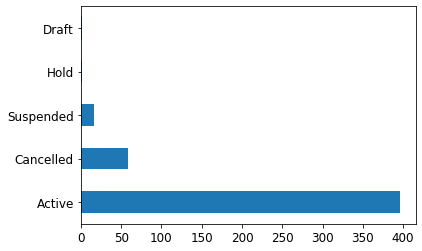

In [259]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.account_status.value_counts().plot.barh();

In [260]:
flds = ['account_status', 'churn_concern', 'pred', 'pred_std']
enc_summ = x[flds].groupby('account_status', as_index=False).mean()
enc_summ

,account_status,churn_concern,pred,pred_std
0,Active,0.020202,0.085991,0.249047
1,Cancelled,0.844828,0.844353,0.104810
2,Draft,1.000000,0.987500,0.111102
3,Hold,0.000000,0.047500,0.212706
4,Suspended,0.000000,0.033281,0.174522


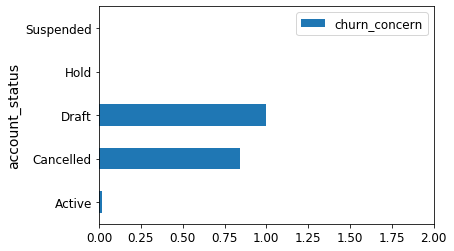

In [261]:
enc_summ = enc_summ[~pd.isnull(enc_summ.churn_concern)]
enc_summ.plot('account_status', 'churn_concern', 'barh', xlim=(0,2));

In [262]:
flds = ['account_status', 'churn_concern', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,churn_concern,pred,pred_std
account_status,,,
Active,0.020202,0.085991,0.249047
Cancelled,0.844828,0.844353,0.104810
Draft,1.000000,0.987500,0.111102
Hold,0.000000,0.047500,0.212706
Suspended,0.000000,0.033281,0.174522


In [263]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

account_status
Suspended    5.243868
Hold         4.478016
Active       2.896189
Cancelled    0.124131
Draft        0.112509
dtype: float64

In [264]:
fi = rf_feat_importance(m, df_trn); fi[:20]

,cols,imp
13,churned,0.531811
40,account_status_Active,0.274668
3,last_active_days,0.099010
45,account_status_nan,0.058246
2,days_active,0.008107
41,account_status_Cancelled,0.005710
44,account_status_Suspended,0.005062
8,plan,0.003183
12,url,0.001830
7,plans,0.001516


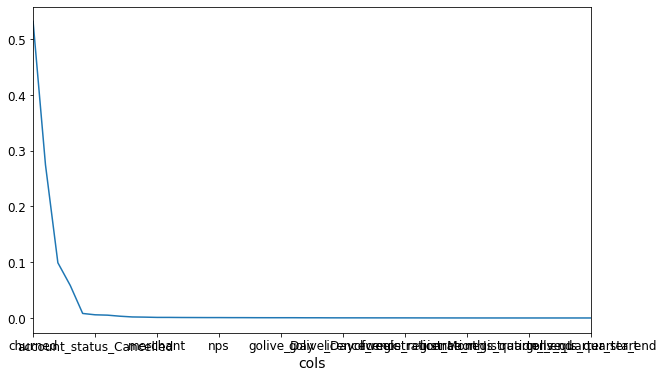

In [265]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [266]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

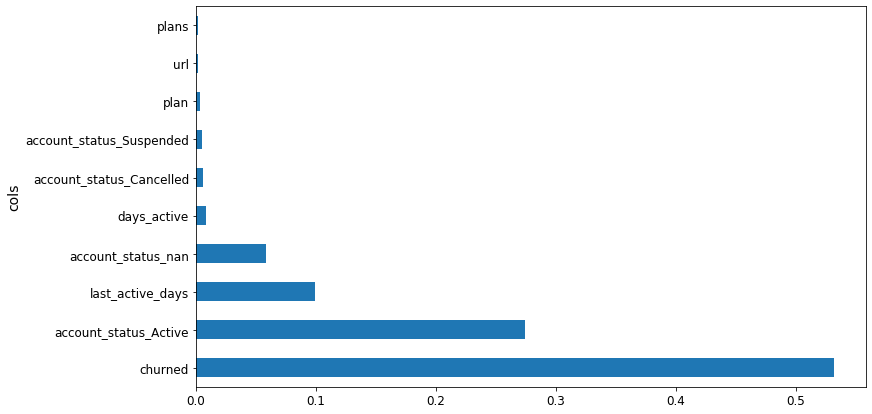

In [267]:
plot_fi(fi[:10]);

In [268]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

7

In [275]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [276]:
df_keep.columns

Index(['churned', 'account_status_Active', 'last_active_days',
       'account_status_nan', 'days_active', 'account_status_Cancelled',
       'account_status_Suspended'],
      dtype='object')

In [277]:
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.049467527903891785, 0.08318846424748384, 0.9900443576404071, 0.9504899225628513, 0.9866988499969602]


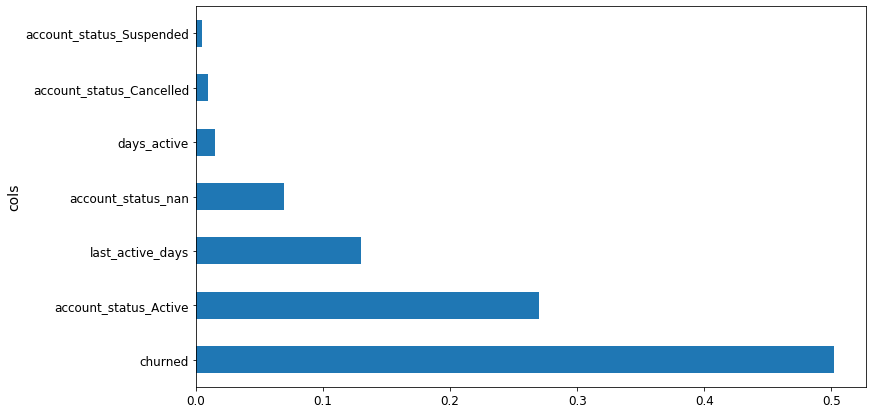

In [278]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [279]:
df_trn2, y_trn, nas = proc_df(df_raw, 'churn_concern', max_n_cat=5)
X_train, X_valid = split_vals(df_trn2, n_trn)

In [280]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.042936718985408885, 0.09099511212500463, 0.9924995627599187, 0.9407615725829744, 0.9863495008686048]


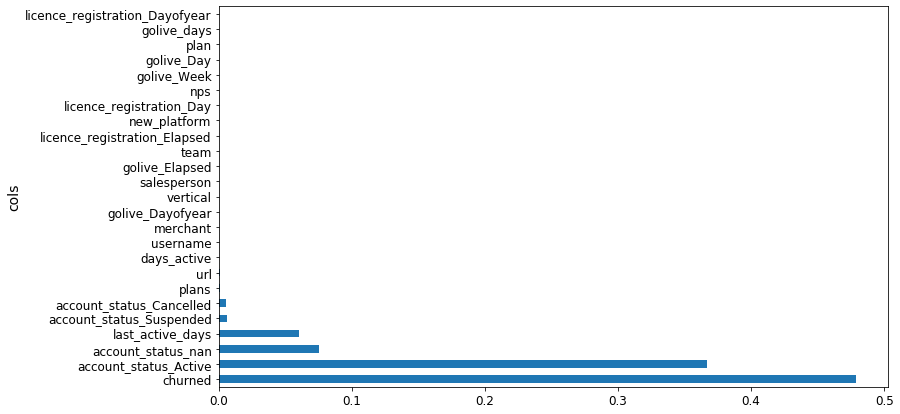

In [281]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

In [282]:
from scipy.cluster import hierarchy as hc

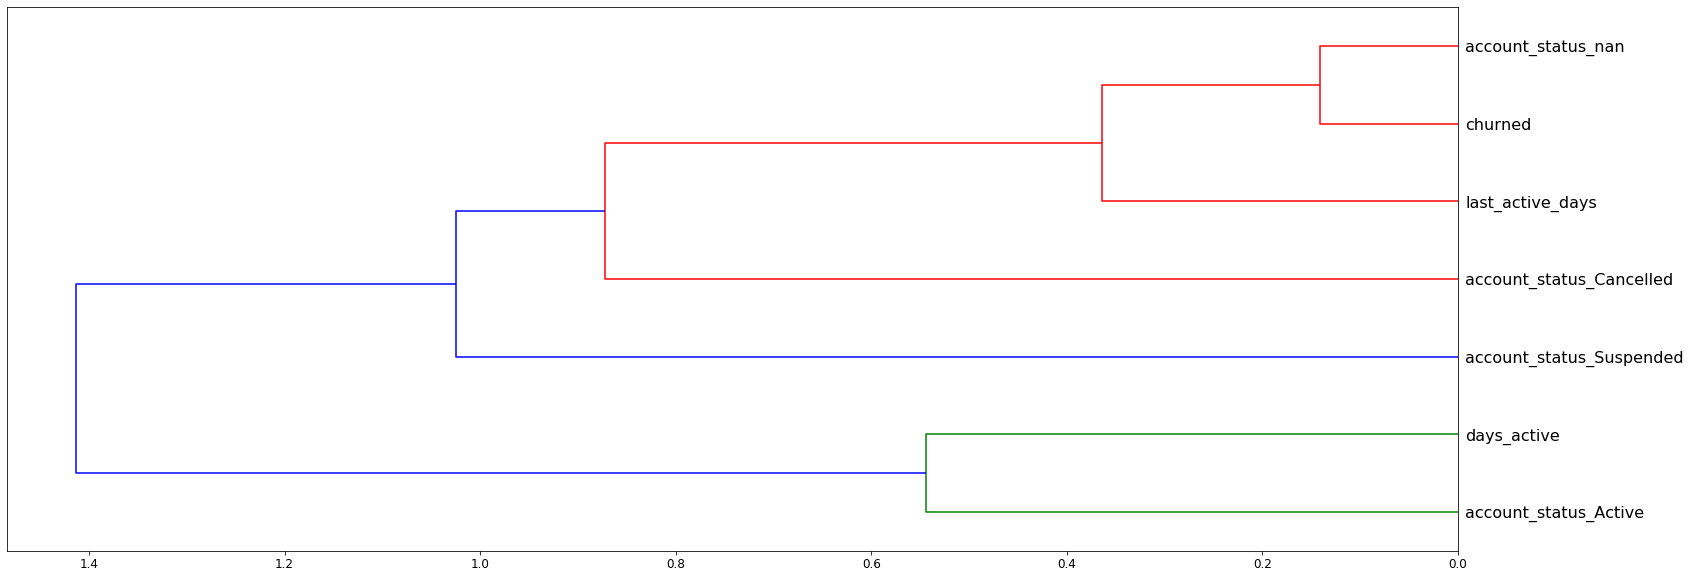

In [283]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 5)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(26,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [284]:
from pdpbox import pdp
from plotnine import *

In [285]:
df_trn2, y_trn, nas = proc_df(df_raw, 'churn_concern', max_n_cat=5)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

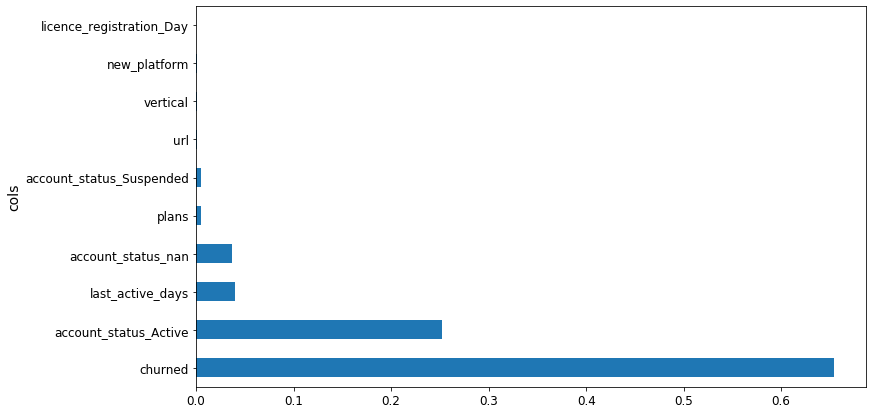

In [286]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

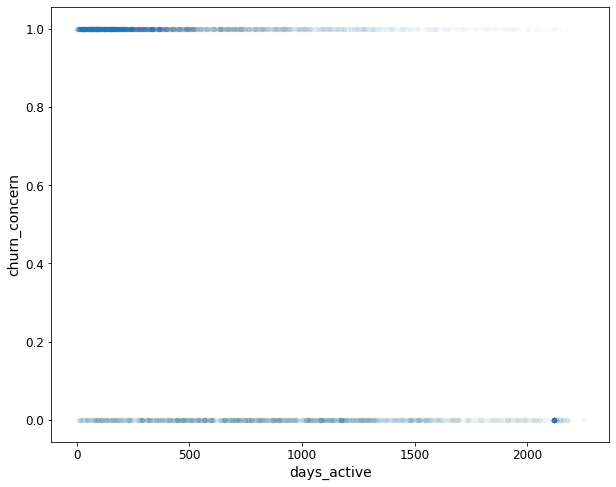

In [293]:
df_raw.plot('days_active', 'churn_concern', 'scatter', alpha=0.01, figsize=(10,8));

In [130]:
x_all = get_sample(df_raw[df_raw.days_active>10], 500)

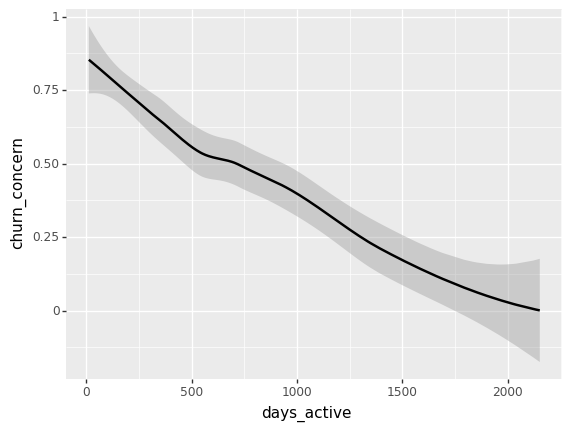

<ggplot: (7561959001)>

In [135]:
ggplot(x_all, aes('days_active', 'churn_concern'))+stat_smooth(se=True, method='loess')